<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/EfficientNetKerasv0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pillow

In [3]:
!pip install cloud_tpu_client

     |████████████████████████████████| 57 kB 4.4 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.272 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow import keras
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights=None)
import PIL.Image
import pathlib


In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [6]:
batch_size = 4
IMG_SIZE = 240
original_dataset_dir = 'drive/MyDrive/mri_images/train'

In [7]:
data_dir = pathlib.Path(original_dataset_dir)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 510 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)


['0', '1', '2']


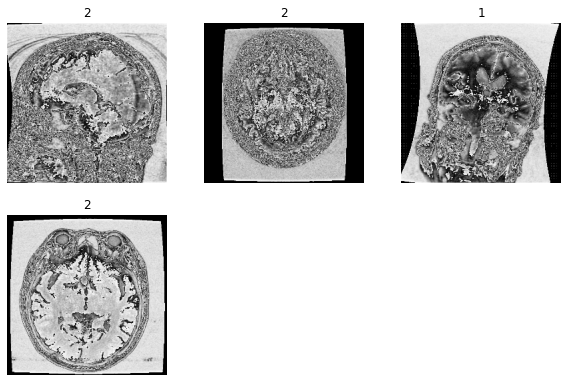

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 240, 240, 3)
(4,)


In [13]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

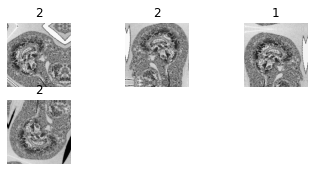

In [14]:
for image, label in train_ds.take(1):
    for i in range(4):
        aug_img = img_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [24]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Epoch 1/20
511/511 - 43s - loss: 2.1314 - accuracy: 0.7311 - val_loss: 2.1276 - val_accuracy: 0.8039
Epoch 2/20
511/511 - 28s - loss: 2.1137 - accuracy: 0.7605 - val_loss: 3.4850 - val_accuracy: 0.6451
Epoch 3/20
511/511 - 27s - loss: 1.8600 - accuracy: 0.7791 - val_loss: 1.8939 - val_accuracy: 0.7941
Epoch 4/20
511/511 - 27s - loss: 1.7037 - accuracy: 0.7777 - val_loss: 1.2851 - val_accuracy: 0.8216
Epoch 5/20
511/511 - 28s - loss: 1.5191 - accuracy: 0.7713 - val_loss: 0.8274 - val_accuracy: 0.8216
Epoch 6/20
511/511 - 28s - loss: 1.3102 - accuracy: 0.7894 - val_loss: 1.2707 - val_accuracy: 0.8039
Epoch 7/20
511/511 - 28s - loss: 1.1492 - accuracy: 0.7698 - val_loss: 0.7707 - val_accuracy: 0.8078
Epoch 8/20
511/511 - 27s - loss: 0.8965 - accuracy: 0.7811 - val_loss: 0.6080 - val_accuracy: 0.8373
Epoch 9/20
511/511 - 28s - loss: 0.8308 - accuracy: 0.7796 - val_loss: 0.4257 - val_accuracy: 0.8725
Epoch 10/20
511/511 - 28s - loss: 0.7236 - accuracy: 0.7909 - val_loss: 0.8307 - val_accura

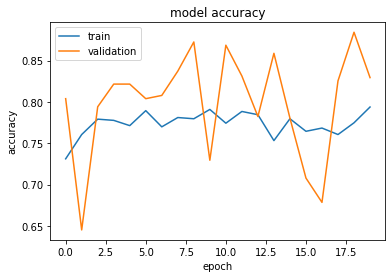

This image most likely belongs to 0 with a 57.58 percent confidence.


In [25]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

    epochs = 20  # @param {type: "slider", min:8, max:80}
    hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)


plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
) 

Epoch 1/50
511/511 - 45s - loss: 0.5452 - accuracy: 0.8217 - val_loss: 0.4253 - val_accuracy: 0.8667
Epoch 2/50
511/511 - 29s - loss: 0.5441 - accuracy: 0.8115 - val_loss: 0.3667 - val_accuracy: 0.8647
Epoch 3/50
511/511 - 29s - loss: 0.4524 - accuracy: 0.8516 - val_loss: 0.3033 - val_accuracy: 0.8922
Epoch 4/50
511/511 - 29s - loss: 0.4286 - accuracy: 0.8477 - val_loss: 0.3873 - val_accuracy: 0.8804
Epoch 5/50
511/511 - 29s - loss: 0.4679 - accuracy: 0.8477 - val_loss: 0.4497 - val_accuracy: 0.8686
Epoch 6/50
511/511 - 29s - loss: 0.4025 - accuracy: 0.8565 - val_loss: 0.2509 - val_accuracy: 0.9196
Epoch 7/50
511/511 - 29s - loss: 0.3877 - accuracy: 0.8668 - val_loss: 0.2445 - val_accuracy: 0.9137
Epoch 8/50
511/511 - 29s - loss: 0.3441 - accuracy: 0.8761 - val_loss: 0.2142 - val_accuracy: 0.9235
Epoch 9/50
511/511 - 29s - loss: 0.3605 - accuracy: 0.8771 - val_loss: 0.2074 - val_accuracy: 0.9255
Epoch 10/50
511/511 - 29s - loss: 0.3800 - accuracy: 0.8766 - val_loss: 0.2601 - val_accura

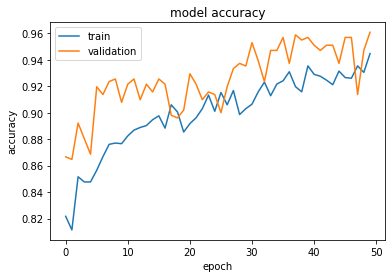

This image most likely belongs to 1 with a 50.13 percent confidence.


In [26]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)



In [19]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 240, 240, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 240, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 240, 3)  7           rescaling_1[0][0]                
_______________________________________________________________________________________